##  Prepare Environment

In [0]:
# will need igraph later for plotting...

%pip install python-igraph

Python interpreter will be restarted.
Collecting python-igraph
 Downloading python-igraph-0.9.11.tar.gz (9.5 kB)
Collecting igraph==0.9.11
 Downloading igraph-0.9.11-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Collecting texttable>=1.6.2
 Downloading texttable-1.6.4-py2.py3-none-any.whl (10 kB)
Building wheels for collected packages: python-igraph
 Building wheel for python-igraph (setup.py): started
 Building wheel for python-igraph (setup.py): finished with status 'done'
 Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9060 sha256=1742eb5edd2da9f51a0f2f99792cc0ad75e57faa5cbbbb64343b87bb0225f85a
 Stored in directory: /root/.cache/pip/wheels/80/cc/db/88e7da87ff0cc3d1f311760bdaea8d531c2b209ec19dfda13c
Successfully built python-igraph
Installing collected packages: texttable, igraph, python-igraph
Successfully installed igraph-0.9.11 python-igraph-0.9.11 texttable-1.6.4
Python interpreter will be restarted.

In [0]:
from graphframes import *
from pyspark.sql.functions import monotonically_increasing_id, desc, col, lit, when
from functools import reduce
import matplotlib.pyplot as plt
from igraph import *

## Create Graph
This part is taken over from the lab. However we only use the euroTripGraph here, so the US delays graph is removed, as well as all the queries we already did in the lab.

In [0]:
# Exercise inspired by tutorial at https://databricks.com/blog/2016/03/16/on-time-flight-performance-with-graphframes-for-apache-spark.html

# TODO: change the following paths to the ones from your csv file uploads

# International airports list, taken from http://openflights.org/data.html (see airports.dat)
airports = spark.read.csv("/FileStore/tables/airports.csv", sep=",", header=True)

# International Flights, also taken from http://openflights.org/data.html (see routes.dat)
routes = spark.read.csv("/FileStore/tables/routes.csv", sep=",", header=True)

display(airports.take(2))

Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689835,145.3919983,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207079887,145.7890015,20,10,U,Pacific/Port_Moresby,airport,OurAirports


In [0]:
# 1. Create Vertices (airports)
# TODO: rename the column that identifies airports with the explicit name "id"
tripVertices = airports.withColumnRenamed("IATA", "id").distinct()

# TODO: Make sure to check that the column was succesfully renamed by displaying again 1 row from the table
display(tripVertices.take(1))

Airport ID,Name,City,Country,id,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689835,145.3919983,5282,10,U,Pacific/Port_Moresby,airport,OurAirports


In [0]:
# 2. Construct the edges and build the GraphFrame

euroTripEdges = routes.withColumnRenamed('Source airport', 'src').withColumnRenamed('Destination airport', 'dst')
#print euroTripEdges.take(1)

euroTripGraph = GraphFrame(tripVertices, euroTripEdges)
print("Routes: %d" % euroTripGraph.edges.count())
print()
print("SAMPLE ROUTE DATA:")
print(euroTripGraph.edges.take(1))
print()

Routes: 67663

SAMPLE ROUTE DATA:
[Row(Airline='2B', Airline ID='410', src='AER', Source airport ID='2965', dst='KZN', Destination airport ID='2990', Codeshare=None, Stops='0', Equipment='CR2')]

## Subgraphs
Create a subgraph of the euroTripGraph with only the routes within Switzerland
and plot this subgraph (as there is no plotting within GraphFrames, convert Graph to iGraph)

#### Create subgraph

In [0]:
# print number of vertices and edges in the original graph
print("euroTrip vertices:", euroTripGraph.vertices.count())
print("euroTrip edges:", euroTripGraph.edges.count())
print()

#create the subgraph
chTripGraph = euroTripGraph.filterVertices("country=='Switzerland'")

# now print the number of vertices and edges of the subgraph and compare
print("chTrip vertices:", chTripGraph.vertices.count())
print("chTrip edges:", chTripGraph.edges.count())

euroTrip vertices: 7184
euroTrip edges: 67663

chTrip vertices: 41
chTrip edges: 10

#### Convert subgraph to igraph

In [0]:
## prepare vertices for igraph

# to convert the GraphFrame to an igraph, we need numeric vertex IDs at the beginning of the dataframes 
# -> "Airport ID" becomes our igraph vertex ID and has to the first column of the new vertex dataframe ("id" is the IATA code which is not numeric)

display(chTripGraph.vertices.limit(1))
# "Airport ID" already is in 1st position, good!

# rename the "id" column to "label"
ig_vertices = chTripGraph.vertices.withColumnRenamed("id", "label")

# delete minor airports (those with no IATA code)
ig_vertices = ig_vertices.filter(ig_vertices.label != "\\N")

display(ig_vertices)

Airport ID,Name,City,Country,id,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1664,Les Eplatures Airport,Les Eplatures,Switzerland,\N,LSGC,47.08390045,6.792840004,3368,1,E,Europe/Zurich,airport,OurAirports


Airport ID,Name,City,Country,label,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1676,Bern Belp Airport,Bern,Switzerland,BRN,LSZB,46.91410065,7.497149944,1674,1,E,Europe/Zurich,airport,OurAirports
6928,Lausanne-Bl��cherette Airport,Lausanne,Switzerland,QLS,LSGL,46.54529953,6.616670132,2041,1,E,Europe/Zurich,airport,OurAirports
1675,Lugano Airport,Lugano,Switzerland,LUG,LSZA,46.00429916,8.910579681,915,1,E,Europe/Zurich,airport,OurAirports
1665,Geneva Cointrin International Airport,Geneva,Switzerland,GVA,LSGG,46.23809814,6.108950138,1411,1,E,Europe/Paris,airport,OurAirports
1680,Samedan Airport,Samedan,Switzerland,SMV,LSZS,46.53409958,9.884110451,5600,1,E,Europe/Zurich,airport,OurAirports
7027,Interlaken Air Base,Interlaken,Switzerland,ZIN,LSMI,46.6766014,7.8790798,0,1,E,Europe/Zurich,airport,OurAirports
8613,Buochs Airport,Buochs,Switzerland,BXO,LSZC,46.974444,8.396944,1475,1,E,Europe/Zurich,airport,OurAirports
1678,Z�_rich Airport,Zurich,Switzerland,ZRH,LSZH,47.46469879,8.54916954,1416,1,E,Europe/Zurich,airport,OurAirports
1679,St Gallen Altenrhein Airport,Altenrhein,Switzerland,ACH,LSZR,47.48500061,9.560770035,1306,1,E,Europe/Zurich,airport,OurAirports
6931,Neuchatel Airport,Neuchatel,Switzerland,QNC,LSGN,46.95750046,6.864719868,1427,1,E,Europe/Zurich,airport,OurAirports


In [0]:
## prepare edges for igraph

# -> "Source airport ID" and "Destination airport ID" have to be the first two columns of the edge df

display(chTripGraph.edges.limit(1))

# move 'src' and 'dst' to the beginning (necessary for igraph)
ig_edges = chTripGraph.edges.select("Source airport ID", "Destination airport ID", "src", "dst", "Airline", "Airline ID", "Codeshare", "Stops", "Equipment")

display(ig_edges.limit(1))  

Airline,Airline ID,src,Source airport ID,dst,Destination airport ID,Codeshare,Stops,Equipment
F7,2420,GVA,1665,LUG,1675,null,0,S20


Source airport ID,Destination airport ID,src,dst,Airline,Airline ID,Codeshare,Stops,Equipment
1665,1675,GVA,LUG,F7,2420,null,0,S20


In [0]:
# create igraph version of graph
igGraph = Graph.DataFrame(edges=ig_edges.toPandas(), directed=True,
                          vertices=ig_vertices.toPandas())
igGraph.summary()

Out[8]: 'IGRAPH DN-- 13 10 -- \n+ attr: Altitude (v), City (v), Country (v), DST (v), ICAO (v), Latitude (v), Longitude (v), Name (v), Source (v), Timezone (v), Type (v), Tz database time zone (v), label (v), name (v), Airline (e), Airline ID (e), Codeshare (e), Equipment (e), Stops (e), dst (e), src (e)'

In [0]:
print(igGraph)

IGRAPH DN-- 13 10 --
+ attr: Altitude (v), City (v), Country (v), DST (v), ICAO (v), Latitude (v),
 Longitude (v), Name (v), Source (v), Timezone (v), Type (v), Tz database
 time zone (v), label (v), name (v), Airline (e), Airline ID (e), Codeshare
 (e), Equipment (e), Stops (e), dst (e), src (e)
+ edges (vertex names):
1665->1675, 1665->1678, 1675->1665, 1678->1665, 1665->1678, 1675->1678,
1678->1665, 1678->1675, 1665->1678, 1678->1665

#### Plot subgraph

In [0]:
# change default image size
plt.rcParams.get('figure.figsize')  # [6.0, 4.0]
plt.rcParams["figure.figsize"] = (12,8)

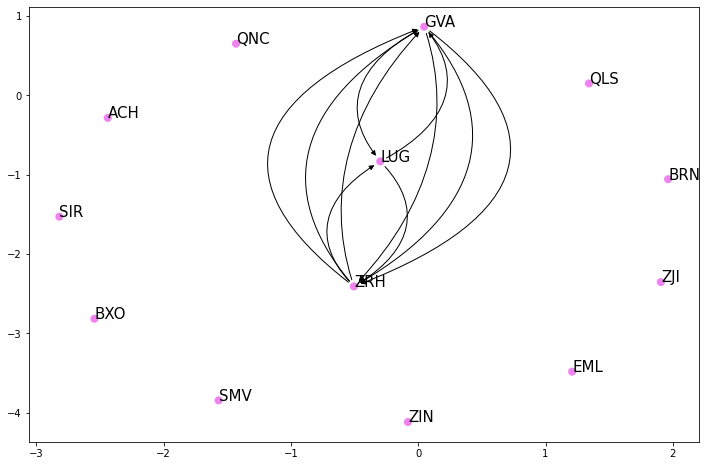

In [0]:
## use matlab version of igraph plotting, as it is not dependent on Cairo (could not find suitable version of pycairo)
## see https://igraph.org/python/tutorial/latest/visualisation.html#graph-plotting

fig, ax = plt.subplots()

# plot(igGraph, target=ax, layout="fruchterman_reingold", vertex_size=7, vertex_label_size=15,
#     vertex_label=igGraph.vs["label"], vertex_label_dist = 1, vertex_color="violet")

plot(igGraph, target=ax, layout="kamada_kawai", vertex_size=7, vertex_label_size=15,
     vertex_label=igGraph.vs["label"], vertex_label_dist = 1, vertex_color="violet")


## Importance of individual airports

Here we want to compare the importance of the individual airports. We first do this using the pagerank algorithm and then compare the results with what we would get by simply looking at incoming and outgoing edges (using degree functions).

### PageRank

In [0]:
results = euroTripGraph.pageRank(resetProbability=0.15, tol=0.01)

In [0]:
# look at overall results
results.vertices.select("id", "name", "city", "pagerank").orderBy(desc("pagerank")).show(20)


+---+--------------------+-----------------+------------------+
 id| name| city| pagerank|
+---+--------------------+-----------------+------------------+
ATL|Hartsfield Jackso...| Atlanta| 46.48995914824333|
ORD|Chicago O'Hare In...| Chicago|29.195343271537112|
LAX|Los Angeles Inter...| Los Angeles| 28.26837222304177|
DFW|Dallas Fort Worth...|Dallas-Fort Worth| 26.59979019971547|
CDG|Charles de Gaulle...| Paris|25.014572895062035|
LHR|London Heathrow A...| London| 24.80460126635334|
SIN|Singapore Changi ...| Singapore| 24.09586333315911|
DEN|Denver Internatio...| Denver|23.514241302478837|
FRA|Frankfurt am Main...| Frankfurt|22.467568410199462|
JFK|John F Kennedy In...| New York|22.404955956436485|
PEK|Beijing Capital I...| Beijing|22.398919573481777|
DME|Domodedovo Intern...| Moscow|21.355148026092998|
MIA|Miami Internation...| Miami| 20.79839778137618|
AMS|Amsterdam Airport...| Amsterdam|20.796579031705534|
SYD|Sydney Kingsford ...| Sydney|20.592723012554494|
IST|Atat�_rk Internat...| Istanbul|19.709280420878972|
DXB|Dubai Internation...| Dubai|19.514489866012376|
BKK|Suvarnabhumi Airport| Bangkok| 18.2499212112601|
ICN|Incheon Internati...| Seoul| 18.07700564603326|
YYZ|Lester B. Pearson...| Toronto| 17.98460434616942|
+---+--------------------+-----------------+------------------+
only showing top 20 rows

In [0]:
# look at the results just within Europe
results.vertices.select("id", "name", "city", "pagerank")\
    .orderBy(desc("pagerank"))\
    .filter(col("dst")=="E")\
    .show(20)

+---+--------------------+-----------------+------------------+
 id| name| city| pagerank|
+---+--------------------+-----------------+------------------+
CDG|Charles de Gaulle...| Paris|25.014572895062035|
LHR|London Heathrow A...| London| 24.80460126635334|
FRA|Frankfurt am Main...| Frankfurt|22.467568410199462|
AMS|Amsterdam Airport...| Amsterdam|20.796579031705534|
IST|Atat�_rk Internat...| Istanbul|19.709280420878972|
BCN|Barcelona Interna...| Barcelona|17.489697144904696|
MAD|Adolfo Su��rez Ma...| Madrid|15.941786525322355|
MUC|Munich Internatio...| Munich|15.558002112923683|
LGW|London Gatwick Ai...| London|15.160452300298932|
BRU| Brussels Airport| Brussels| 14.7539189544512|
FCO|Leonardo da Vinci...| Rome|14.685421207485152|
VIE|Vienna Internatio...| Vienna| 13.41429806194746|
MAN| Manchester Airport| Manchester| 13.12526195119893|
ARN|Stockholm-Arlanda...| Stockholm| 13.0923877460418|
DUS|D�_sseldorf Inter...| Duesseldorf|12.149797806351755|
PMI|Palma De Mallorca...|Palma de Mallorca|11.975190304097373|
ORY| Paris-Orly Airport| Paris|11.705629641685363|
ATH|Eleftherios Veniz...| Athens| 11.3786171392478|
LIS|Lisbon Portela Ai...| Lisbon|10.952805569900619|
CPH|Copenhagen Kastru...| Copenhagen|10.861531528000576|
+---+--------------------+-----------------+------------------+
only showing top 20 rows

### PageRank vs Degrees

In [0]:
## now add the number of incoming and outgoing edges to our results dataframe (as well as number of total edges)

outDeg = euroTripGraph.outDegrees
inDeg = euroTripGraph.inDegrees
rv = results.vertices

# the following join loses all pageranked airports with no incoming and/or outgoing flights
# which is quite acceptable as these are not of interest here
results2 = outDeg.join(rv, outDeg.id == rv.id, "outer")\
    .join(inDeg, outDeg.id == inDeg.id, "outer")\
    .select(rv.id, rv.Name, rv.City, rv.DST, rv.pagerank, 
            (inDeg.inDegree+outDeg.outDegree).alias("TotalDegree"),
            outDeg.outDegree, inDeg.inDegree)\
    .orderBy(desc(rv.pagerank))

results2.show(20)
#display(results2.take(20))

+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
 id| Name| City|DST| pagerank|TotalDegree|outDegree|inDegree|
+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
ATL|Hartsfield Jackso...| Atlanta| A| 46.48995914824333| 1826| 915| 911|
ORD|Chicago O'Hare In...| Chicago| A|29.195343271537112| 1108| 558| 550|
LAX|Los Angeles Inter...| Los Angeles| A| 28.26837222304177| 990| 492| 498|
DFW|Dallas Fort Worth...|Dallas-Fort Worth| A| 26.59979019971547| 936| 469| 467|
CDG|Charles de Gaulle...| Paris| E|25.014572895062035| 1041| 524| 517|
LHR|London Heathrow A...| London| E| 24.80460126635334| 1051| 527| 524|
SIN|Singapore Changi ...| Singapore| N| 24.09586333315911| 820| 408| 412|
DEN|Denver Internatio...| Denver| A|23.514241302478837| 735| 361| 374|
FRA|Frankfurt am Main...| Frankfurt| E|22.467568410199462| 990| 497| 493|
JFK|John F Kennedy In...| New York| A|22.404955956436485| 911| 456| 455|
PEK|Beijing Capital I...| Beijing| U|22.398919573481777| 1069| 535| 534|
DME|Domodedovo Intern...| Moscow| N|21.355148026092998| 649| 324| 325|
MIA|Miami Internation...| Miami| A| 20.79839778137618| 734| 368| 366|
AMS|Amsterdam Airport...| Amsterdam| E|20.796579031705534| 903| 453| 450|
SYD|Sydney Kingsford ...| Sydney| O|20.592723012554494| 410| 208| 202|
IST|Atat�_rk Internat...| Istanbul| E|19.709280420878972| 719| 358| 361|
DXB|Dubai Internation...| Dubai| U|19.514489866012376| 710| 356| 354|
BKK|Suvarnabhumi Airport| Bangkok| U| 18.2499212112601| 656| 326| 330|
ICN|Incheon Internati...| Seoul| U| 18.07700564603326| 740| 370| 370|
YYZ|Lester B. Pearson...| Toronto| A| 17.98460434616942| 636| 319| 317|
+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
only showing top 20 rows

In [0]:
# and just the European results
results2.filter(col("dst")=="E").show(20)

+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
 id| Name| City|DST| pagerank|TotalDegree|outDegree|inDegree|
+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
CDG|Charles de Gaulle...| Paris| E|25.014572895062035| 1041| 524| 517|
LHR|London Heathrow A...| London| E| 24.80460126635334| 1051| 527| 524|
FRA|Frankfurt am Main...| Frankfurt| E|22.467568410199462| 990| 497| 493|
AMS|Amsterdam Airport...| Amsterdam| E|20.796579031705534| 903| 453| 450|
IST|Atat�_rk Internat...| Istanbul| E|19.709280420878972| 719| 358| 361|
BCN|Barcelona Interna...| Barcelona| E|17.489697144904696| 783| 391| 392|
MAD|Adolfo Su��rez Ma...| Madrid| E|15.941786525322355| 661| 330| 331|
MUC|Munich Internatio...| Munich| E|15.558002112923683| 728| 368| 360|
LGW|London Gatwick Ai...| London| E|15.160452300298932| 708| 356| 352|
BRU| Brussels Airport| Brussels| E| 14.7539189544512| 631| 316| 315|
FCO|Leonardo da Vinci...| Rome| E|14.685421207485152| 662| 331| 331|
VIE|Vienna Internatio...| Vienna| E| 13.41429806194746| 616| 308| 308|
MAN| Manchester Airport| Manchester| E| 13.12526195119893| 627| 316| 311|
ARN|Stockholm-Arlanda...| Stockholm| E| 13.0923877460418| 439| 219| 220|
DUS|D�_sseldorf Inter...| Duesseldorf| E|12.149797806351755| 570| 285| 285|
PMI|Palma De Mallorca...|Palma de Mallorca| E|11.975190304097373| 548| 271| 277|
ORY| Paris-Orly Airport| Paris| E|11.705629641685363| 404| 201| 203|
ATH|Eleftherios Veniz...| Athens| E| 11.3786171392478| 403| 197| 206|
LIS|Lisbon Portela Ai...| Lisbon| E|10.952805569900619| 435| 214| 221|
CPH|Copenhagen Kastru...| Copenhagen| E|10.861531528000576| 457| 229| 228|
+---+--------------------+-----------------+---+------------------+-----------+---------+--------+
only showing top 20 rows

As expected, ranking by pagerank is not completely different from ranking by degrees only. However, there are some differences. Airports like LA, Dallas or Sidney seem to be more important than expected by simply looking at their degree values (which makes sense). In Europe, the same is true for Madrid or Stockholm for example.

Astonishingly for our use case, indegrees and outdegrees vary for most of the destinations (even if not by much). This might be caused by codeshared flights or simply incompleteness of the data.

In [0]:
# and out of curiosity: find ranking and number of flights for Zurich

euroTripGraph.edges.filter((col("dst")=="ZRH")|(col("src")=="ZRH")).groupBy().count().show()
results2.filter(col("id")=="ZRH").show()

+-----+
count|
+-----+
 494|
+-----+

+---+---------------+------+---+-----------------+-----------+---------+--------+
 id| Name| City|DST| pagerank|TotalDegree|outDegree|inDegree|
+---+---------------+------+---+-----------------+-----------+---------+--------+
ZRH|Z�_rich Airport|Zurich| E|10.82836058169691| 494| 247| 247|
+---+---------------+------+---+-----------------+-----------+---------+--------+

## Motif finding

Next we would like to explore the options for pattern matching in our data.

### Stateless motif finding

#### Find least important airport
(This is not motif finding yet, just preparations for what follows. We will need this for the next two motifs.)

In [0]:
## First, find the least important airport

# get minimum pagerank value for European airports
minEuropeanPagerank = results.vertices.select("pagerank")\
    .filter(col("dst")=="E")\
    .groupBy()\
    .min("pagerank")

print("minimum European Pagerank:", minEuropeanPagerank.collect()[0]["min(pagerank)"])
# display(minEuropeanPagerank)

# get all European airports with minimum pagerank value
# make sure they have any incoming and outgoing flights at all (degree)
lia = results2.select("id", "name", "city", "pagerank", "inDegree", "outDegree")\
    .filter((col("dst")=="E") &\
            (col("pagerank")==minEuropeanPagerank.collect()[0]["min(pagerank)"]))\
    .orderBy(desc("outDegree"))
lia.show(5)

leastImportantAirport = lia.orderBy(desc("outDegree"), desc("inDegree")).collect()[0]["id"]

print("least important European airport:", leastImportantAirport)

minimum European Pagerank: 0.2771372342589875
+---+--------------------+-----------------+------------------+--------+---------+
 id| name| city| pagerank|inDegree|outDegree|
+---+--------------------+-----------------+------------------+--------+---------+
SIC| Sinop Airport| Sinop|0.2771372342589875| 1| 1|
VDA|Ovda Internationa...| Ovda|0.2771372342589875| null| 1|
 \N| Zell Am See Airport| Zell am See|0.2771372342589875| null| null|
 \N|La Fert�� Alais A...| La Ferte Alais|0.2771372342589875| null| null|
QKT| Wevelgem Airport|Kortrijk-vevelgem|0.2771372342589875| null| null|
+---+--------------------+-----------------+------------------+--------+---------+
only showing top 5 rows

least important European airport: SIC

#### a) 3 hops from least important airport
Let's find out how far (where) we can go starting at the least important airport (according to pagerank algorithm) with 3 flights (2 stops) at most.

In [0]:
motifs = euroTripGraph.find("(src)-[h1]->(c1); \
                            (c1)-[h2]->(c2); \
                            (c2)-[h3]->(dst)")\
    .filter("(h1.stops==0) and (h2.stops==0) and (h3.stops == 0) and\
             (src.id == '" + str(leastImportantAirport) + "')")
display(motifs)

src,h1,c1,h2,c2,h3,dst
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, PUE, 7962, null, 0, DHT)","List(7962, Puerto Obaldia Airport, Puerto Obaldia, Panama, PUE, MPOA, 8.667, -77.418, 223, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PUE, 7962, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, DAV, 1867, null, 0, 100 F50)","List(1867, Enrique Malek International Airport, David, Panama, DAV, MPDA, 8.390999794, -82.43499756, 89, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, DAV, 1867, SJO, 1885, null, 0, F50)","List(1885, Juan Santamaria International Airport, San Jose, Costa Rica, SJO, MROC, 9.993860245, -84.20880127, 3021, -6, U, America/Costa_Rica, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, DAV, 1867, null, 0, 100 F50)","List(1867, Enrique Malek International Airport, David, Panama, DAV, MPDA, 8.390999794, -82.43499756, 89, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, DAV, 1867, PAC, 1869, null, 0, 100 F50)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, CHX, 1866, null, 0, F50)","List(1866, Cap Manuel Ni��o International Airport, Changuinola, Panama, CHX, MPCH, 9.458640099, -82.51679993, 19, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, CHX, 1866, BOC, 1865, null, 0, F50)","List(1865, Bocas Del Toro International Airport, Bocas Del Toro, Panama, BOC, MPBO, 9.340849876, -82.25080109, 10, -5, U, America/Panama, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, BOC, 1865, null, 0, F50)","List(1865, Bocas Del Toro International Airport, Bocas Del Toro, Panama, BOC, MPBO, 9.340849876, -82.25080109, 10, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, BOC, 1865, PAC, 1869, null, 0, F50)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, 

In [0]:
# show results

journeys = motifs.selectExpr("src.City as start", "c1.City as stop1", "c2.City as stop2", "dst.City as dest").distinct()  # distinct to get rid of codeshares
#display(journeys)

# remove the last destination if it has been visited before
journeys = journeys.withColumn("dest", when(journeys.dest==journeys.stop1, " ")\
    .otherwise(journeys.dest))

display(journeys)

start,stop1,stop2,dest
Sinop,Panama,Bocas Del Toro,
Sinop,Panama,Puerto Obaldia,
Sinop,Panama,David,
Sinop,Panama,Changuinola,Bocas Del Toro
Sinop,Panama,David,San Jose
Sinop,Panama,Bocas Del Toro,San Jose


Ok, interesting result... From the least important airport in Europe (which is Sinop airport in Turkey) we can get to 5 different places in Panama or to San Jose in Costa Rica. If we don't want to take more than three flights we can't go anywhere in Europe.

#### b) Fly on an Airbus A380

Again we start at the least important airport. This time we want to find out how many flights we need until we can board an Airbus A380. (I.e. the last flight of the journey must be with an Airbus A380 and the journey should have as few stops as possible.)

Note: The airplane type used for a specific route can be found in the routes.Equipment field. '380' is the IATA code for Airbus A380 (source: planes.dat on https://openflights.org/data.html)

In [0]:
# make sure I understand how to formulate the path generically (practising only...)

path = "; ".join([f"(v{i})-[e{i}]->(v{i+1})" for i in range(4)])
print(path)


(v0)-[e0]->(v1); (v1)-[e1]->(v2); (v2)-[e2]->(v3); (v3)-[e3]->(v4)

In [0]:
# actual motif finding...
# start with only one flight and then increase the number of flights until A380 is found

for hops in range(1,10):
    path = "; ".join([f"(v{i})-[e{i}]->(v{i+1})" for i in range(hops)])
    #print(path)
    
    filter = f"(v0.id = 'SIC') and (e{hops-1}.Equipment = '380')"
    #print(filter)
    
    motifs = euroTripGraph.find(path).filter(filter)
    nof_connections = motifs.groupBy().count().collect()[0]["count"]
    
    if nof_connections > 0: break

print("number of necessary flights:", hops-1)
print("number of different journeys (incl. codeshares):", nof_connections)


number of necessary flights: 4
number of different journeys (incl. codeshares): 6

In [0]:
# display results

colnames = ["start",*[f"stop{i}" for i in range(1,hops)],"dest"]

cities = [f"v{i}.City as {colnames[i]}" for i in range(hops+1)]

journeys = motifs.selectExpr(*cities).distinct()  # distinct to get rid of codeshares
display(journeys)

start,stop1,stop2,stop3,stop4,dest
Sinop,Panama,David,San Jose,Los Angeles,Guangzhou
Sinop,Panama,Bocas Del Toro,San Jose,Los Angeles,Guangzhou
Sinop,Panama,Bocas Del Toro,San Jose,Los Angeles,Melbourne
Sinop,Panama,David,San Jose,Los Angeles,Melbourne


In [0]:
# do the same thing manually (safety check only, codeshares not removed this time)

motifs = euroTripGraph.find("(src)-[h1]->(c1); \
                            (c1)-[h2]->(c2); \
                            (c2)-[h3]->(c3); \
                            (c3)-[h4]->(c4); \
                            (c4)-[h5]->(dst)")\
    .filter("(src.id == 'SIC') and (h5.equipment == '380')")

display(motifs)


src,h1,c1,h2,c2,h3,c3,h4,c4,h5,dst
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, DAV, 1867, null, 0, 100 F50)","List(1867, Enrique Malek International Airport, David, Panama, DAV, MPDA, 8.390999794, -82.43499756, 89, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, DAV, 1867, SJO, 1885, null, 0, F50)","List(1885, Juan Santamaria International Airport, San Jose, Costa Rica, SJO, MROC, 9.993860245, -84.20880127, 3021, -6, U, America/Costa_Rica, airport, OurAirports)","List(DL, 2009, SJO, 1885, LAX, 3484, null, 0, 757)","List(3484, Los Angeles International Airport, Los Angeles, United States, LAX, KLAX, 33.94250107, -118.4079971, 125, -8, A, America/Los_Angeles, airport, OurAirports)","List(DL, 2009, LAX, 3484, CAN, 3370, Y, 0, 380)","List(3370, Guangzhou Baiyun International Airport, Guangzhou, China, CAN, ZGGG, 23.39240074, 113.2990036, 50, 8, U, Asia/Shanghai, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, DAV, 1867, null, 0, 100 F50)","List(1867, Enrique Malek International Airport, David, Panama, DAV, MPDA, 8.390999794, -82.43499756, 89, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, DAV, 1867, SJO, 1885, null, 0, F50)","List(1885, Juan Santamaria International Airport, San Jose, Costa Rica, SJO, MROC, 9.993860245, -84.20880127, 3021, -6, U, America/Costa_Rica, airport, OurAirports)","List(DL, 2009, SJO, 1885, LAX, 3484, null, 0, 757)","List(3484, Los Angeles International Airport, Los Angeles, United States, LAX, KLAX, 33.94250107, -118.4079971, 125, -8, A, America/Los_Angeles, airport, OurAirports)","List(CZ, 1767, LAX, 3484, CAN, 3370, null, 0, 380)","List(3370, Guangzhou Baiyun International Airport, Guangzhou, China, CAN, ZGGG, 23.39240074, 113.2990036, 50, 8, U, Asia/Shanghai, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, DAV, 1867, null, 0, 100 F50)","List(1867, Enrique Malek International Airport, David, Panama, DAV, MPDA, 8.390999794, -82.43499756, 89, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, DAV, 1867, SJO, 1885, null, 0, F50)","List(1885, Juan Santamaria International Airport, San Jose, Costa Rica, SJO, MROC, 9.993860245, -84.20880127, 3021, -6, U, America/Costa_Rica, airport, OurAirports)","List(DL, 2009, SJO, 1885, LAX, 3484, null, 0, 757)","List(3484, Los Angeles International Airport, Los Angeles, United States, LAX, KLAX, 33.94250107, -118.4079971, 125, -8, A, America/Los_Angeles, airport, OurAirports)","List(AA, 24, LAX, 3484, MEL, 3339, Y, 0, 380)","List(3339, Melbourne International Airport, Melbourne, Australia, MEL, YMML, -37.6733017, 144.8430023, 434, 10, O, Australia/Hobart, airport, OurAirports)"
"List(6783, Sinop Airport, Sinop, Turkey, SIC, LTCM, 42.01580048, 35.06639862, 20, 3, E, Europe/Istanbul, airport, OurAirports)","List(7P, 1500, SIC, 6783, PAC, 1869, null, 0, DHT)","List(1869, Marcos A. Gelabert International Airport, Panama, Panama, PAC, MPMG, 8.973340034, -79.55560303, 31, -5, U, America/Panama, airport, OurAirports)","List(7P, 1500, PAC, 1869, BOC, 18

### Stateful motif finding

Now we would like to travel from Zurich to New York. On our way there we would like to visit four other cities, of which only two may be in Europe (but it's ok if only one or even none of them is in Europe). Of course these four cities mustn't be Zurich or New York again.

This get's quite cumbersome with stateless motif finding, so we better remember how many European cities we have already included in my trip (hence "stateful").

Note: Our data doesn't really include the information which cities lie in Europe. We take the DST field from the airport data instead which is good enough for training purposes (DST: daylight savings time, with 'E' for Europe).

In [0]:
motifs = euroTripGraph.find("(src)-[h1]->(c1); \
                            (c1)-[h2]->(c2); \
                            (c2)-[h3]->(c3); \
                            (c3)-[h4]->(c4); \
                            (c4)-[h5]->(dst)")\
    .filter("(src.id = 'ZRH') and (dst.id = 'JFK')")

airports = [f"c{i}" for i in range(1,5)]
# print(airports)    # ['c1', 'c2', 'c3', 'c4']


## 1st) sequence query: count number of European airports

updateEuStops = \
    lambda cnt, continent: when(continent == 'E', cnt+1).otherwise(cnt)

condition = \
    reduce(lambda cnt, airport: updateEuStops(cnt, col(airport).DST), airports, lit(0))



## 2nd) make sure none of the in-between-stops is equal to Zurich or New York
##      (remove all 3 New York airports)
##      (not really a sequence query...)

checkForbidden = \
    lambda cnt, city: when(city.isin('ZRH','JFK','IDL','LGA'), cnt+1).otherwise(cnt)

condition2 = \
    reduce(lambda cnt, airport: checkForbidden(cnt, col(airport).id), airports, lit(0))


## apply the filters to the motifs
## (also add the conditions to the dataframe so as to be able to perform safety checks afterwards)

selectedJourneys = motifs.where((condition <= 2) & \
                                (condition2 == 0)) \
                         .withColumn("nof_europe", condition) \
                         .withColumn("check", condition2)

print("\n number of possible journeys:", \
      selectedJourneys.groupBy().count().collect()[0]["count"])


number of possible journeys: 1217645789

Ok well, there seem to be quite a lot of possibilities...

In [0]:
# display some results

colnames = ["start",*[f"stop{i}" for i in range(1,hops)],"dest"]
cities = ["src.City as Start",
          *[f"c{i}.City as {colnames[i]}" for i in range(1,hops)], 
          "dst.City as Dest"]

journeys = selectedJourneys.selectExpr(*cities).distinct().limit(15)
display(journeys)

Start,stop1,stop2,stop3,stop4,Dest
Zurich,Brindisi,Milano,Dakar,Washington,New York
Zurich,Brindisi,Geneva,Cairo,Dubai,New York
Zurich,Brindisi,Geneva,Algier,Dakar,New York
Zurich,Brindisi,Munich,Shanghai,Seattle,New York
Zurich,Brindisi,Munich,Atlanta,Montego Bay,New York
Zurich,Brindisi,Rome,Yekaterinburg,Beijing,New York
Zurich,Brindisi,Rome,Montreal,Dallas-Fort Worth,New York
Zurich,Brindisi,Rome,Dubai,Cairo,New York
Zurich,Brindisi,Rome,Boston,Philadelphia,New York
Zurich,Brindisi,Rome,Boston,Cancun,New York


In [0]:
# perform some safety checks

selectedJourneys.select("c1.DST", "c2.DST", "c3.DST","c4.DST","nof_europe")\
    .filter(selectedJourneys.nof_europe==0)\
    .show(5)
selectedJourneys.select("c1.DST", "c2.DST", "c3.DST","c4.DST","nof_europe")\
    .filter(selectedJourneys.nof_europe==1)\
    .show(5)
selectedJourneys.select("c1.DST", "c2.DST", "c3.DST","c4.DST","nof_europe")\
    .filter(selectedJourneys.nof_europe==2)\
    .show(5)
selectedJourneys.select("c1.DST", "c2.DST", "c3.DST","c4.DST","nof_europe")\
    .filter(selectedJourneys.nof_europe>2)\
    .show(5)

+---+---+---+---+----------+
DST|DST|DST|DST|nof_europe|
+---+---+---+---+----------+
 U| U| U| U| 0|
 U| U| U| U| 0|
 U| U| U| U| 0|
 U| U| U| U| 0|
 U| U| U| U| 0|
+---+---+---+---+----------+
only showing top 5 rows

+---+---+---+---+----------+
DST|DST|DST|DST|nof_europe|
+---+---+---+---+----------+
 E| N| N| N| 1|
 E| N| N| U| 1|
 E| N| N| U| 1|
 E| N| N| U| 1|
 E| N| N| U| 1|
+---+---+---+---+----------+
only showing top 5 rows

+---+---+---+---+----------+
DST|DST|DST|DST|nof_europe|
+---+---+---+---+----------+
 E| E| U| U| 2|
 E| E| U| U| 2|
 E| E| U| U| 2|
 E| E| U| U| 2|
 E| E| U| U| 2|
+---+---+---+---+----------+
only showing top 5 rows

+---+---+---+---+----------+
DST|DST|DST|DST|nof_europe|
+---+---+---+---+----------+
+---+---+---+---+----------+

## Shortest Paths

Here we want to try out the algorithms for finding distances and shortest paths.

#### Distances

Several friends from different countries want to pass their holidays together in a nice place.

Their home destinations are Zurich, Munich, Friedrichshafen, Paris, Carcassonne and London Gatwick.

Holiday candidates are Rome, Tenerife, Sicily, Maldives and Phuket. 

We want to find the distances (number of stops) to all possible destinations for all participants.

In [0]:
home = ['ZRH','MUC','CDG','CCF','LGW','FDH']
landmarks = ['FCO','TFS','CTA','MLE','HKT']

results = euroTripGraph.shortestPaths(landmarks)

results.select("id", "City", "distances").filter(col("id").isin(home)).show(1) # doesn't show full result
display(results.select("id", "City", "distances").filter(col("id").isin(home)))

+---+-----+--------------------+
 id| City| distances|
+---+-----+--------------------+
CDG|Paris|{FCO -> 1, HKT ->...|
+---+-----+--------------------+
only showing top 1 row

id,City,distances
CDG,Paris,"Map(FCO -> 1, HKT -> 2, CTA -> 1, TFS -> 1, MLE -> 2)"
FDH,Friedrichshafen,"Map(FCO -> 2, HKT -> 3, CTA -> 2, TFS -> 2, MLE -> 2)"
LGW,London,"Map(FCO -> 1, HKT -> 2, CTA -> 1, TFS -> 1, MLE -> 1)"
ZRH,Zurich,"Map(FCO -> 1, HKT -> 2, CTA -> 1, TFS -> 1, MLE -> 2)"
CCF,Carcassonne,"Map(FCO -> 2, HKT -> 3, CTA -> 2, TFS -> 2, MLE -> 3)"
MUC,Munich,"Map(FCO -> 1, HKT -> 2, CTA -> 1, TFS -> 1, MLE -> 2)"


#### Shortest paths

Our friends decide to travel to Sicily. Let's now find the shortest connections for those two that do not have a direct connection.

In [0]:
journeys = euroTripGraph.bfs("(id == 'CCF') or (id == 'FDH')", "id == 'CTA'")
journeys.show(1)
display(journeys.selectExpr("from.City as from","v1.City as connection","to.City as to").distinct().orderBy("from"))

+--------------------+--------------------+--------------------+--------------------+--------------------+
 from| e0| v1| e1| to|
+--------------------+--------------------+--------------------+--------------------+--------------------+
{382, Friedrichsh...|{LH, 3320, FDH, 3...|{340, Frankfurt a...|{IG, 3463, FRA, 3...|{1509, Catania-Fo...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row

from,connection,to
Carcassonne,Dublin,Catania
Carcassonne,Eindhoven,Catania
Friedrichshafen,Cologne,Catania
Friedrichshafen,Frankfurt,Catania
Friedrichshafen,Hamburg,Catania
Friedrichshafen,Berlin,Catania
Friedrichshafen,Duesseldorf,Catania
